<a href="https://colab.research.google.com/github/vahehambardzumyan/nlp_recommendation_system/blob/main/NLP_Recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Armenian News website analysis**

![a](https://wallpapers.com/images/hd/vintage-newspaper-5s06sfhqd9915v0v.jpg)


# 0. Problem Statement



Improve Armenian NLP quality: Current LLMs perform poorly in

*   Armenian because they are trained on limited and low-quality Armenian datasets. Analyzing real news text helps identify linguistic patterns and improve future Armenian NLP models.
*   Understand how media shapes public perception: Armenian news frequently covers sensitive political, economic, and security issues. Automated analysis helps map how tone, bias, and sentiment evolve over time.






# 1 . Data **Scraping**

Scrapping data using BeautifulSoup. Below is just a simple example.

In [ ]:
!pip install -q selenium beautifulsoup4

In [ ]:
url = f"https://www.panarmenian.net/arm/news/328247/"
page = requests.get(url, timeout=10)
soup = BeautifulSoup(page.text, "html.parser")
print(soup.prettify)

I choose the website https://www.panarmenian.net/arm/news.
For this website I choose id,  title, date, body, images, videos, author and category. I put them into a pandas dataframe.

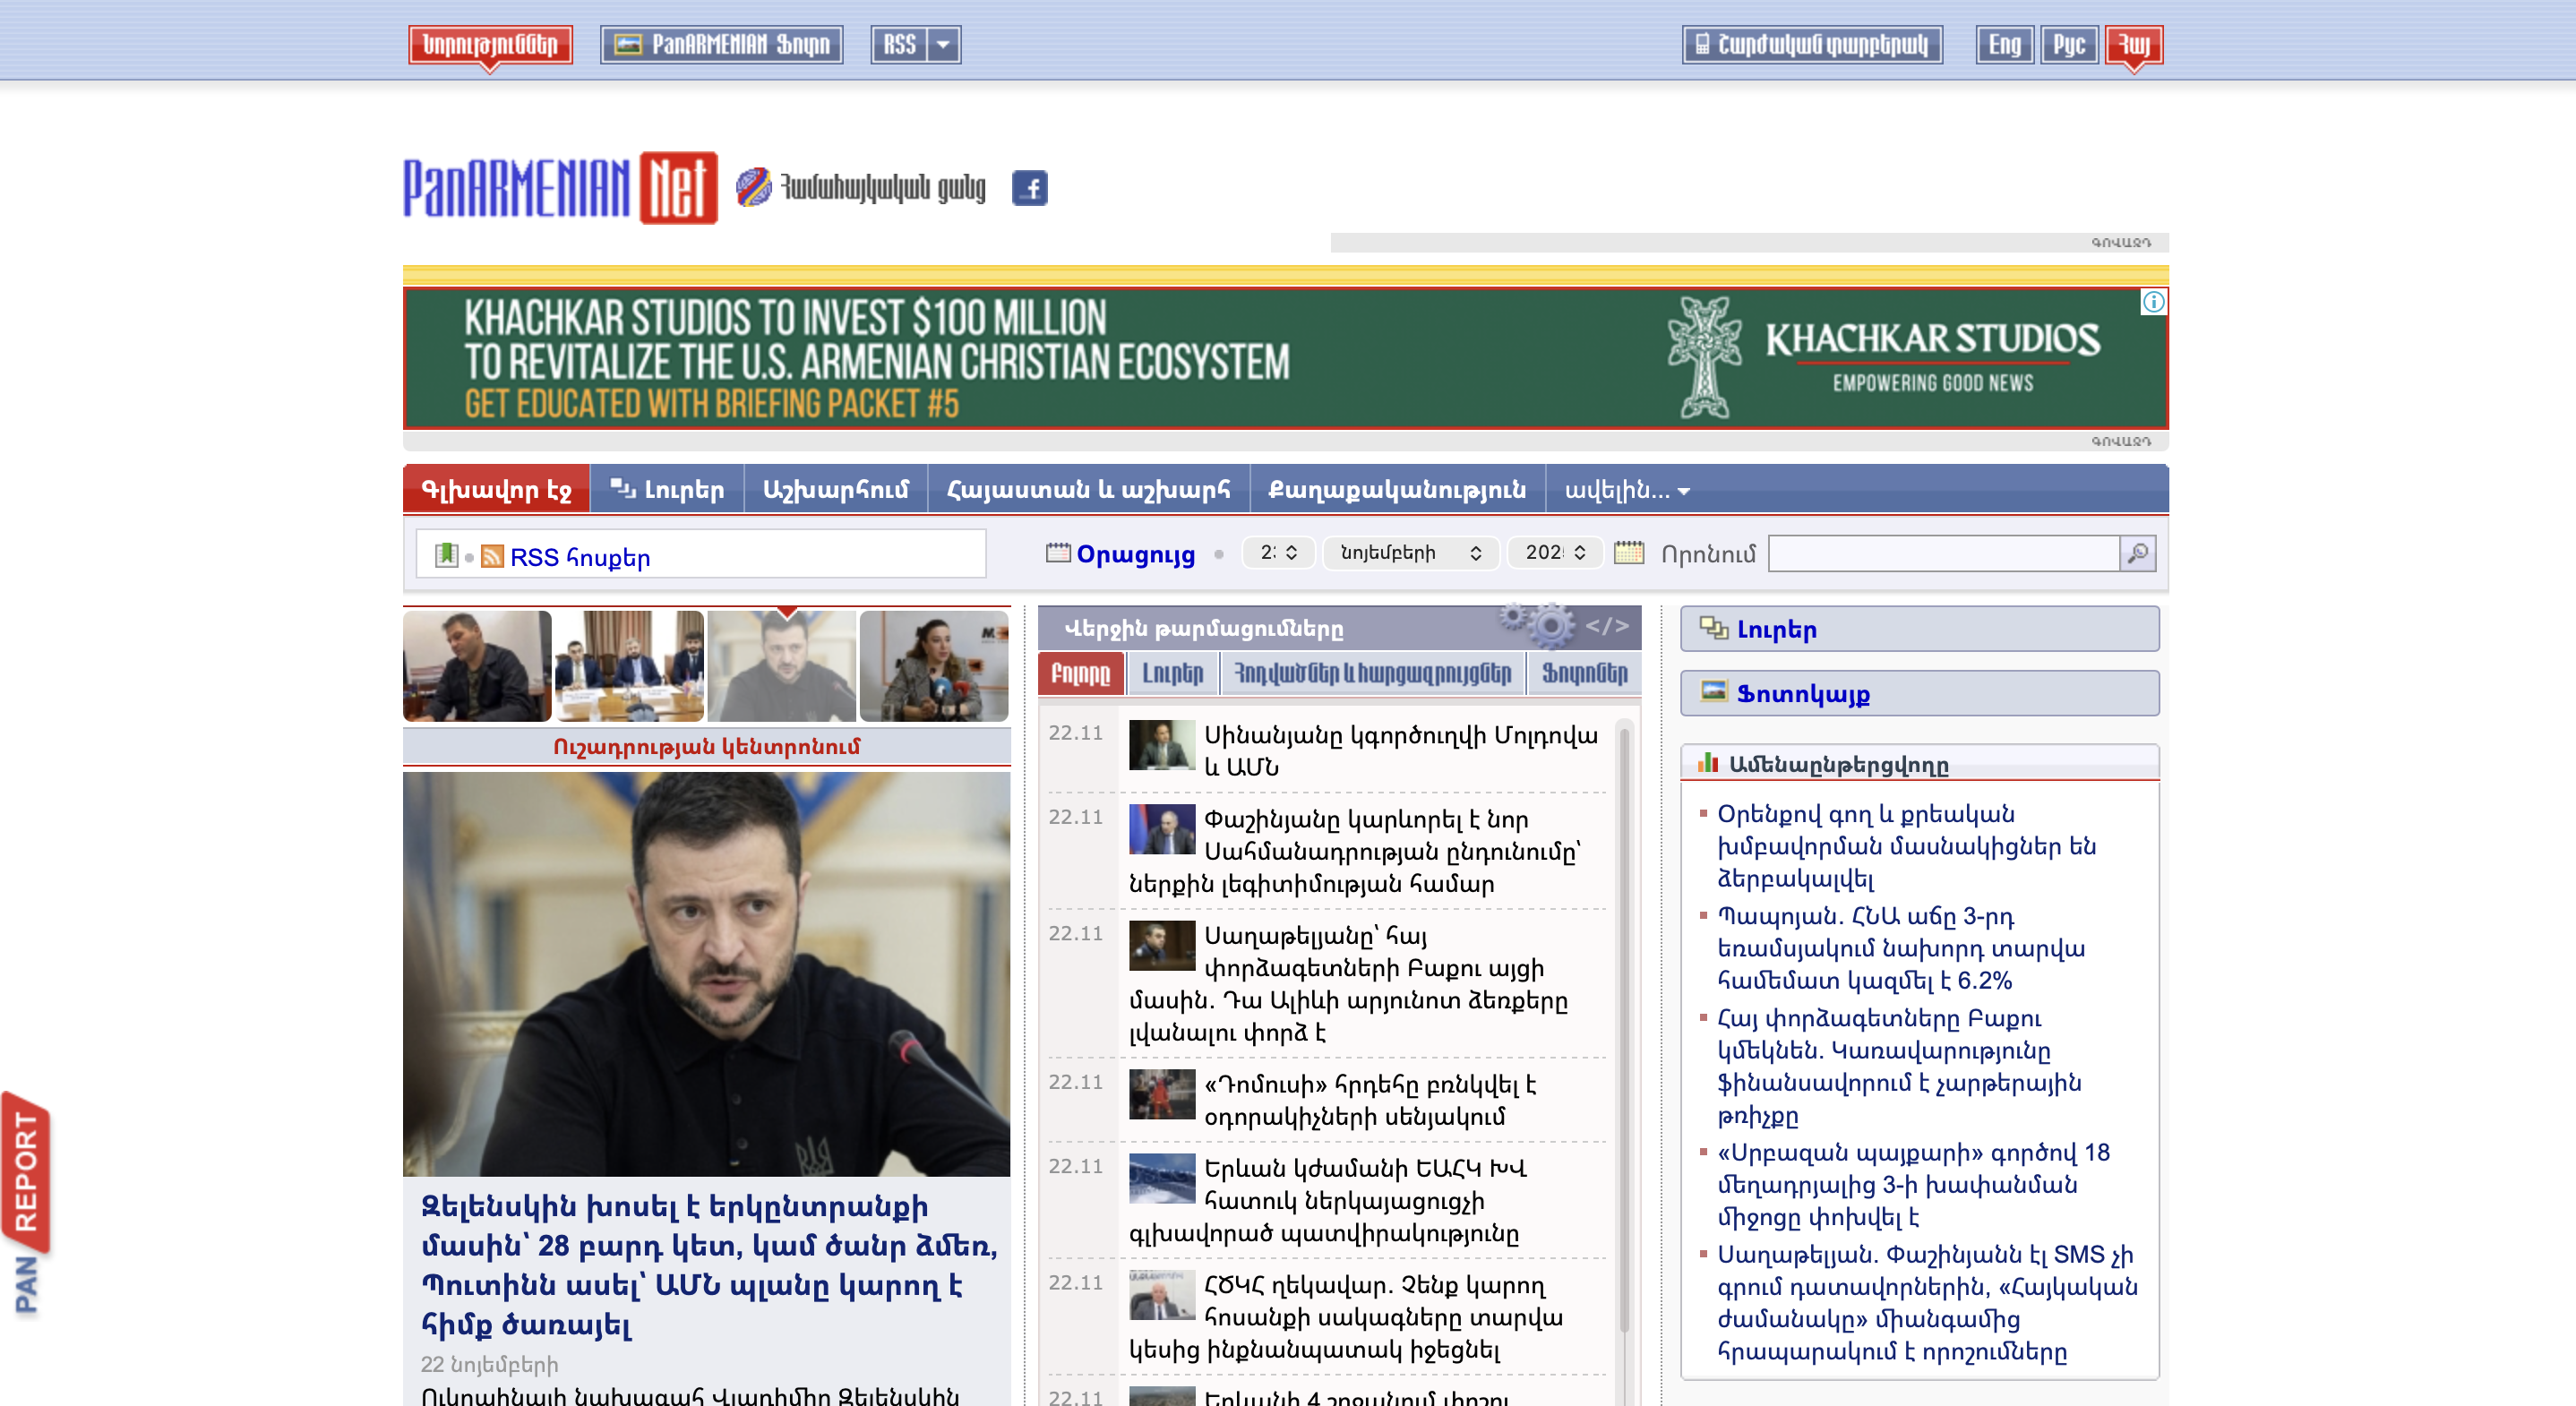

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from time import sleep

data = {
    "id": [],
    "title": [],
    "datetime": [],
    "author": [],
    "body": [],
    "images": [],
    "category": [],
    "videos": []
}

for i in range(323252, 328252):
    url = f"https://www.panarmenian.net/arm/news/{i}/"
    print(f"Scraping {url} ...")
    try:
        page = requests.get(url, timeout=10)
        if page.status_code != 200:
            print(f"⚠️ Skipping {i} (status code {page.status_code})")
            continue

        soup = BeautifulSoup(page.text, "html.parser")

        # Check if article exists (e.g., page not found)
        if soup.find("title") and "404" in soup.find("title").text:
            print(f"🚫 Article {i} not found")
            continue

        # Extract fields safely
        title = soup.find('h1', class_='article_title')
        datetime_tag = soup.find('div', class_='article_date')
        body_div = soup.find('div', class_='article_body')
        selected_menu = soup.select_one('.menu_item.selected a')

        data["id"].append(i)
        data["title"].append(title.get_text(strip=True) if title else None)
        data["datetime"].append(datetime_tag.get_text(strip=True) if datetime_tag else None)

        author_tag = soup.select_one('.article_body strong')
        data["author"].append(author_tag.get_text(strip=True) if author_tag else None)

        if body_div:
            paragraphs = body_div.find_all('p')
            data["body"].append(' '.join(p.get_text(strip=True) for p in paragraphs))
            data["images"].append([img['src'] for img in body_div.find_all('img', src=True)])
        else:
            data["body"].append(None)
            data["images"].append([])

        data["category"].append(selected_menu.get_text(strip=True) if selected_menu else None)
        data["videos"].append([v['src'] for v in soup.find_all(['iframe', 'video'], src=True)])

    except Exception as e:
        print(f"❌ Error scraping article {i}: {e}")
        # Add None placeholders to keep data aligned
$

    sleep(0.5)  # Small delay to avoid being blocked

# Convert to DataFrame
df = pd.DataFrame(data)
print(df.info())
print(df.head())


In [ ]:
df.to_csv('panarmenian_news.csv', index=False)

In [ ]:
df_copy=df.copy()

In [ ]:
df= pd.read_csv('panarmenian_news.csv')

# 2 .  EDA and Data Cleaning

## 2.1 Data Cleaning

In [ ]:
import pandas as pd
df = pd.read_excel('panarmenian_news.xlsx', header=1)

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

First of all I delete the full nullish articles.

In [ ]:
df.dropna(subset=['title'], inplace=True)

In [ ]:
df.isnull().sum()

The Author section gives us nothing , so I delte it also.

In [ ]:
pd.unique(df['author'])

In [ ]:
df.drop(columns=['author'], inplace=True)

In [ ]:
df.isnull().sum()

The date come to us in armenian, I chnged to "YYYY-MM-DD" format.

In [ ]:
import pandas as pd
import numpy as np

arm_months = {
    "հունվարի": 1,
    "փետրվարի": 2,
    "մարտի": 3,
    "ապրիլի": 4,
    "մայիսի": 5,
    "հունիսի": 6,
    "հուլիսի": 7,
    "օգոստոսի": 8,
    "սեպտեմբերի": 9,
    "հոկտեմբերի": 10,
    "նոյեմբերի": 11,
    "դեկտեմբերի": 12
}

def convert_arm_datetime(s):
    # Handle None, NaN, empty string
    if pd.isna(s) or s is None or str(s).strip() == "":
        return None

    try:
        # Split date and time
        date_part, time_part = s.split('-')
        date_part = date_part.strip()
        time_part = time_part.strip()

        # Parse date
        day, month_arm, year = date_part.split()
        month_num = arm_months.get(month_arm)

        if month_num is None:   # unknown month
            return None

        # Clean time (remove AMT)
        time_part = time_part.replace("AMT", "").strip()

        # Auto-detect HH:MM or HH:MM:SS
        t_parts = time_part.split(':')
        if len(t_parts) == 2:
            hour, minute = t_parts
            second = "00"
        elif len(t_parts) == 3:
            hour, minute, second = t_parts
        else:
            return None

        # Build final datetime string
        return f"{year}-{month_num:02d}-{int(day):02d} {hour}:{minute}:{second}"

    except:
        return None  # return None if parsing fails


df["datetime_changed"] = df["datetime"].apply(convert_arm_datetime)


In [ ]:
df.drop(columns=['datetime'], inplace=True)
df.rename(columns={'datetime_changed': 'datetime'}, inplace=True)

In [ ]:
df.info()

Deleteing the first inuseful suffix from body text.

In [ ]:
df['body']= df['body'].str.replace('PanARMENIAN.Net- ', '')
df['body']= df['body'].str.replace('PanARMENIAN.Net-', '')

In [ ]:
df.head()

For Images and videos, I need to save just their quantity. So I transfore them too. I also checked if some article contains carousel , I also save them.


In [ ]:
df[df['videos'].str.len() > 0]

In [ ]:
df['has_video'] = df['videos'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0)
df.drop(columns=['videos'], inplace=True)

In [ ]:
df['has_carousell'] = df['images'].apply(
    lambda imgs: 1 if isinstance(imgs, list) and "https://static.pn.am/images/scroll_l.gif" in imgs else 0
)

In [ ]:
import ast
df['images_count'] = df['images'].apply(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

In [ ]:
df.drop(columns=['images'], inplace=True)

As I havent view count data, I adde some 'sintetic' collumn to do EDA.

In [ ]:
df['title_word_count'] = df['title'].str.split().str.len()

In [ ]:
df['body_word_count'] = df['body'].str.split().str.len()


In [ ]:
df.head()

##2.2 EDA




In [ ]:
df.info()

In [ ]:
df.describe()

Here we can see than in the image count we have i lot of outliers. The cause can be the advertisment in some article.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8,5))
df['category'].value_counts().plot(kind='bar')

In [ ]:
plt.boxplot(df['images_count'])
plt.title('Image Count Distribution')
plt.ylabel('Image Count')
plt.show()

Here we can see than in the image count we have i lot of outliers. The cause can be the advertisment in some articles.



To handle outlier , I use IQR technique. Then I fill them with the mode of image count.

In [ ]:
pd.unique(df['images_count'])

In [ ]:
Q1 = np.percentile(df['images_count'], 25, interpolation = 'midpoint')
Q2 = np.percentile(df['images_count'], 50, interpolation = 'midpoint')
Q3 = np.percentile(df['images_count'], 75, interpolation = 'midpoint')

print('Q1 25 percentile of the given data is, ', Q1)
print('Q1 50 percentile of the given data is, ', Q2)
print('Q1 75 percentile of the given data is, ', Q3)

IQR = Q3 - Q1
print('Interquartile range is', IQR)

low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
print('Lower limit is', low_lim)
print('Upper limit is', up_lim)

In [ ]:
df['images_count'] = df['images_count'].where(
    df['images_count'].between(low_lim, up_lim), other=np.nan
)


In [ ]:
df['images_count'].fillna(df['images_count'].mode()[0])

In [ ]:
plt.hist(df['body_word_count'])

In [ ]:
plt.hist(df['title_word_count'])

In [ ]:
plt.boxplot(df['title_word_count'])

In [ ]:
plt.boxplot(df['body_word_count'])

Handling the same way the body word count. Idealy is not correct, but I do it for ANOVA.(I assume th bode word count is view count for demonstarate some techniques)

In [ ]:
Q1 = np.percentile(df['body_word_count'], 25, interpolation = 'midpoint')
Q2 = np.percentile(df['body_word_count'], 50, interpolation = 'midpoint')
Q3 = np.percentile(df['body_word_count'], 75, interpolation = 'midpoint')

print('Q1 25 percentile of the given data is, ', Q1)
print('Q1 50 percentile of the given data is, ', Q2)
print('Q1 75 percentile of the given data is, ', Q3)

IQR = Q3 - Q1
print('Interquartile range is', IQR)

low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
print('Lower limit is', low_lim)
print('Upper limit is', up_lim)

In [ ]:
df['body_word_count'].clip(lower=low_lim, upper=up_lim)

Correlation matrix with numerical values.

In [ ]:
import seaborn as sns

numerical_vars = ['title_word_count', 'body_word_count']

# Compute the correlation matrix
corr = df[numerical_vars].corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

##2.3 Hypothesis Testing: ANOVA


*Null hypothesis (H₀):  There is no difference in the mean body_word_count between Politics, Sports, and Economy articles.*


*Alternative hypothesis (H₁): At least one category has a different mean body_word_count.*

In [ ]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Extract the groups
politics = df[df['category'] == 'Քաղաքականություն']['body_word_count']
sports   = df[df['category'] == 'Սպորտ']['body_word_count']
economy  = df[df['category'] == 'Տնտեսություն']['body_word_count']

# -----------------------------
# 1. ANOVA using scipy (quick F-test)
# -----------------------------
f_stat, p_value = stats.f_oneway(politics, sports, economy)

print("=== Scipy one-way ANOVA ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ Reject H0: There is a significant difference in mean body_word_count between categories.")
else:
    print("→ Fail to reject H0: No significant difference in mean body_word_count between categories.")

# -----------------------------
# 2. More detailed ANOVA table with statsmodels
# -----------------------------
# Create a temporary dataframe with only the needed columns
anova_df = df[df['category'].isin(['Քաղաքականություն', 'Սպորտ', 'Տնտեսություն'])][['category', 'body_word_count']].copy()

# Fit the model
model = ols('body_word_count ~ C(category)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\n=== Statsmodels ANOVA table ===")
print(anova_table)

# -----------------------------
# 3. Post-hoc test (Tukey's HSD) - to see exactly which pairs differ
# -----------------------------
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=anova_df['body_word_count'],
                          groups=anova_df['category'],
                          alpha=0.05)

print("\n=== Tukey's HSD post-hoc test ===")
print(tukey)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='body_word_count', data=anova_df, palette='Set2', boxprops=dict(alpha=0.8))
sns.stripplot(x='category', y='body_word_count', data=anova_df, color='black', alpha=0.4, size=4)
plt.title('Distribution of body_word_count by Category', fontsize=16, pad=20)
plt.xlabel('Category', fontsize=12)
plt.ylabel('body_word_count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Since p < 0.05 , we reject the null hypothesis (H₀) at the 5% significance level.
Interpretation:
The average length  of articles differs significantly depending on the category.


Sports articles are significantly shorter than both Politics and Economy articles (p < 0.001).
All three categories differ significantly from one another (all pairwise p-values < 0.05).

This finding indicates that editorial style, depth of coverage, or content requirements vary substantially across Politics, Sports, and Economy sections.

# **3. Time Series Analysis and  Forecasting**


##3.1 Time Series Analysis

In [ ]:

import matplotlib.pyplot as plt

# 1. Make sure the date column is datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# 2. Count articles per day
daily_counts = df.groupby(df['datetime'].dt.date).size()

# 3. Plot the time-series
plt.figure(figsize=(12,5))
plt.plot(daily_counts.index, daily_counts.values)
plt.xlabel('Day')
plt.ylabel('Number of Articles')
plt.title('Articles per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Here we can see some outlier. In august the employees  was in vacation, or they have some trouble.

In [ ]:
pd.unique(df['category'])

In [ ]:
politics = df.groupby('category').get_group('Քաղաքականություն')
sports = df.groupby('category').get_group('Սպորտ')
economy = df.groupby('category').get_group('Տնտեսություն')
IT = df.groupby('category').get_group('ՏՏ ոլորտ')
Armenia = df.groupby('category').get_group('Հայաստան և աշխարհ')
world = df.groupby('category').get_group('Աշխարհում')
culture = df.groupby('category').get_group('Մշակույթ')
society = df.groupby('category').get_group('Հասարակություն')

Here the demonstation of the time series of article count per category.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# 1. Make sure the datetime column is properly parsed
df['datetime'] = pd.to_datetime(df['datetime'])

# 2. Group by category once (more efficient)
categories = {
    'Քաղաքականություն': 'Politics',
    'Սպորտ': 'Sports',
    'Տնտեսություն': 'Economy',
    'ՏՏ ոլորտ': 'IT Sector',
    'Հայաստան և աշխարհ': 'Armenia & World',
    'Աշխարհում': 'World',
    'Մշակույթ': 'Culture',
    'Հասարակություն': 'Society'
}

# Create a 4×2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()  # Makes indexing easier

for idx, (arm_name, eng_name) in enumerate(categories.items()):
    # Filter the category
    cat_df = df[df['category'] == arm_name].copy()

    # Count articles per day
    daily_counts = cat_df.groupby(cat_df['datetime'].dt.date).size()

    # Plot
    axes[idx].plot(daily_counts.index, daily_counts.values, color='tab:blue', linewidth=1.2)
    axes[idx].set_title(f'{arm_name}\n({eng_name})', fontsize=14, pad=15)
    axes[idx].set_ylabel('Number of Articles')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.suptitle('Daily Article Counts by Category', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

##3.2 Time Series Forecasting: STL


### Robust Seasonal-Trend Decomposition for Daily Data (Perfect for Armenian News Activity, Social Media Posts, etc.)

This notebook performs a **professional-grade time series decomposition** using **STL** (Seasonal-Trend decomposition using LOESS) — the gold standard for analyzing daily data with strong weekly patterns.

### What the Analysis Shows in One Plot

| Component       | Meaning                                                                                   | Typical Pattern in News/Activity Data                  |
|-----------------|-------------------------------------------------------------------------------------------|--------------------------------------------------------|
| **Original**    | Raw daily count of events (articles published, logins, posts, etc.)                       | Spiky + clear weekly cycles                            |
| **Trend**       | Long-term direction (growth or decline) after removing weekly seasonality                | Slowly rising = growing platform, flat = stable        |
| **Seasonal**    | Repeating weekly pattern (e.g., fewer articles on weekends)                               | Huge dips every Saturday–Sunday in Armenian media      |
| **Residual**    | Everything that cannot be explained by trend or weekly cycle → anomalies, holidays, events | Spikes = major news days, protests, elections, etc.    |

### The Core Method: STL = Seasonal-Trend decomposition using LOESS

STL is superior to classical decomposition because:
- It is **robust to outliers**
- The seasonal component can slowly change over time
- It correctly handles missing days

#### Mathematical Principle (Simplified)

STL repeatedly applies **LOESS** (Locally Estimated Scatterplot Smoothing), a non-parametric regression.

The LOESS smoother at point x estimates the value y as a **weighted average** of nearby points:

$$
\hat{y}(x) = \text{weighted linear/polynomial regression in a window around } x
$$

Weights are given by the tricube function:

$$
w_i = \left(1 - \left|\frac{x - x_i}{d}\right|^3\right)^3 \quad \text{for } |x - x_i| < d, \quad \text{else } 0
$$

Where d is the distance to the farthest neighbor inside the smoothing window.

In STL, LOESS is applied multiple times in an alternating fashion:
1. Remove trend → fit seasonal component with LOESS (period = 7 for weekly data)
2. Remove seasonal → fit trend with a very large LOESS window (long-term smoothing)
3. Repeat until convergence

Final model:

$$
\text{Daily Count}_t = \text{Trend}_t + \text{Seasonal}_t + \text{Residual}_t
$$

### Key Parameter in This Notebook

```python
STL(daily_counts, seasonal=7)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL

# 1. Make sure datetime is proper datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# 2. Resample daily counts
daily_counts = df.resample('D', on='datetime').size()
daily_counts = daily_counts.asfreq('D', fill_value=0)  # fill missing days

# 3. STL decomposition
stl = STL(daily_counts, seasonal=7)  # 7 for weekly seasonality (adjust if needed)
result = stl.fit()

# 4. Plot the components
plt.figure(figsize=(14,9))

plt.subplot(4,1,1)
plt.plot(daily_counts, label='Original')
plt.title('Original')
plt.xticks(rotation=60)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.subplot(4,1,2)
plt.plot(result.trend, label='Trend', color='orange')
plt.title('Trend')
plt.xticks(rotation=60)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.subplot(4,1,3)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')
plt.xticks(rotation=60)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.subplot(4,1,4)
plt.plot(result.resid, label='Residual', color='red')
plt.title('Residual')
plt.xticks(rotation=60)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression

# ----------------------------
# 1. Prepare daily counts
# ----------------------------
df['datetime'] = pd.to_datetime(df['datetime'])
# Resample daily counts
daily_counts = df.resample('D', on='datetime').size()
daily_counts = daily_counts.asfreq('D', fill_value=0) # fill missing days
# ----------------------------
# 2. STL decomposition
# ----------------------------
stl = STL(daily_counts, seasonal=7) # weekly seasonality
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
resid = result.resid
# ----------------------------
# 3. Forecast trend (linear extrapolation)
# ----------------------------
trend_df = trend.reset_index()
trend_df.columns = ['day', 'trend'] # name columns properly
trend_df['t'] = np.arange(len(trend_df)) # time index for regression
X = trend_df['t'].values.reshape(-1,1)
y = trend_df['trend'].values # trend values
# Fit linear regression
model = LinearRegression()
model.fit(X, y)
# Forecast next n_days
n_days = 14
future_t = np.arange(len(trend_df), len(trend_df)+n_days).reshape(-1,1)
trend_forecast = model.predict(future_t)
# ----------------------------
# 4. Forecast seasonality (repeat last week)
# ----------------------------
seasonal_forecast = np.tile(seasonal[-7:], int(np.ceil(n_days/7)))[:n_days]
# ----------------------------
# 5. Combine trend + seasonal
# ----------------------------
forecast_series = pd.Series(trend_forecast + seasonal_forecast,
                            index=pd.date_range(daily_counts.index[-1] + pd.Timedelta(days=1),
                                                periods=n_days, freq='D'))


# ----------------------------
# 6. Plot everything — NOW WITH FORECAST IN RED ON ORIGINAL
# ----------------------------
plt.figure(figsize=(15, 10))

# SUBPLOT 1: Original + Forecast overlaid in RED
plt.subplot(4, 1, 1)
plt.plot(daily_counts, label='Historical Data', color='blue', linewidth=1.5)
plt.plot(forecast_series, label='Forecast', color='red', linewidth=2.5, marker='o', markersize=4)

plt.title('Original Time Series + Forecast (in Red)', fontsize=14)
plt.legend()
plt.ylabel('Count')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # adjust if too crowded
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# SUBPLOT 2: Trend + forecasted trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.plot(forecast_series.index, trend_forecast, '--', label='Forecasted Trend', color='darkorange', linewidth=2)
plt.title('Trend')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# SUBPLOT 3: Seasonality + repeated forecast
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.plot(forecast_series.index, seasonal_forecast, '--', label='Repeated Seasonality', color='darkgreen')
plt.title('Seasonality')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# SUBPLOT 4: Final Forecast only
plt.subplot(4, 1, 4)
plt.plot(forecast_series, label='Final Forecast (Trend + Seasonality)',
         color='red', linewidth=2.5, marker='o', markersize=5)
plt.title('Forecasted Articles (Next 14 Days)', fontsize=14)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout(pad=3.0)
plt.show()

# **4. NLP**

##4.1 Embedding

In [ ]:
!pip install transformers torch scikit-learn hdbscan umap-learn matplotlib seaborn

In [ ]:
df.info()

### Semantic Article Recommendation for Armenian News  
### (Zero translation needed — works directly on Armenian text)

This notebook builds a **content-based recommender** that finds the most semantically similar Armenian news articles using **multilingual sentence embeddings** + **cosine similarity**.

No Armenian-specific NLP tools required — everything runs on a single multilingual model that understands Armenian out of the box.

### What the Code Actually Does (Step-by-Step)

| Step | What Happens | Why It Matters |
|------|--------------|----------------|
| 1    | Extract all article titles (or full texts) from your DataFrame → Python list | Input data for the model |
| 2    | Load the multilingual model  <br>`paraphrase-multilingual-MiniLM-L12-v2` | This model supports 50+ languages including **Armenian** and turns any text into a meaningful 384-dimensional vector |
| 3    | Encode every title → matrix of shape `(n_articles × 384)` | Each row is now a numeric “fingerprint” of the article’s meaning |
| 4    | Compute **cosine similarity** between a chosen article and all others | Measures how close two articles are in meaning (not just keywords) |
| 5    | Return the top-N most similar articles with their similarity scores | Ready-to-use recommendations |

### Cosine Similarity Formula (the math behind the ranking)

$$
\text{cosine_similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_{i=1}^{n} A_i B_i }{\sqrt{\sum_{i=1}^{n} A_i^2} \times \sqrt{\sum_{i=1}^{n} B_i^2}}
$$

- **+1** → identical meaning  
- **0**    → no semantic relation  
- **-1** → opposite meaning (rare with sentence embeddings)  
Typical “very similar” Armenian news titles score **0.70 – 0.95**

### How Recommendations Work

1. Pick any article index (e.g., `index_to_test = 42`)
2. The function calculates cosine similarity of that article against **every other article**
3. Sets self-similarity to -1 (so the article doesn’t recommend itself)
4. Sorts descending and returns the top N matches with titles and scores



Hugging Face Link
https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

In [ ]:

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


articles = df['title'].to_list()

# -------------------------------------------------------
# LOAD MULTILINGUAL EMBEDDING MODEL
# 'paraphrase-multilingual-MiniLM-L12-v2' works well for Armenian
# -------------------------------------------------------
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')


embeddings = model.encode(articles)

# -------------------------------------------------------
# FUNCTION: RECOMMEND SIMILAR ARTICLES
# -------------------------------------------------------
def recommend_similar(article_idx, embeddings, articles, top_n=4):
    # Compute cosine similarity of chosen article with all articles
    sims = cosine_similarity([embeddings[article_idx]], embeddings)[0]

    # ignore the article itself
    sims[article_idx] = -1

    # get top-N most similar articles
    top_indices = sims.argsort()[-top_n:][::-1]

    # return results
    return [(i, articles[i], sims[i]) for i in top_indices]




##4.2 News recommendation System

In [ ]:
def print_armenian_news_recommendation(article_idx, embeddings, articles, top_n=4):
    # Get recommendations (skip the article itself)
    recs = recommend_similar(article_idx, embeddings, articles, top_n=top_n + 5)
    recs = [r for r in recs if r[0] != article_idx][:top_n]

    # Header with Armenian touch
    print("\n" + "═" * 80)
    print(" " * 22 + "ՀԱՅԱՍՏԱՆԻ ՆՈՐՈՒԹՅՈՒՆՆԵՐ" + " " * 22)  # "ARMENIAN NEWS" in Armenian
    print(" " * 28 + "Խելացի առաջարկություններ 🇦🇲")          # "Smart recommendations"
    print("═" * 80)

    # Original article
    print(f"\n🔥 ԳԼԽԱՎՈՐ ՆՅՈՒԹԸ (Հոդված #{article_idx})\n")
    print("📰", articles[article_idx][:600].strip())
    if len(articles[article_idx]) > 600:
        print("   ... (կարդալ ավելին)")

    # Recommendations
    print("\n" + "━" * 80)
    print("✨ ՁԵԶ ՀԵՏՔՐՔՐԵՑՆՈՂ ԿԼԻՆԵՆ ՆԱԵՎ ՍՐԵՆՔ")  # "You may also like these"
    print("━" * 80 + "\n")

    medals = ["🥇 1-ին", "🥈 2-րդ", "🥉 3-րդ", "4-րդ"]
    for i, (idx, text, score) in enumerate(recs):
        bar = "█" * int(score * 50)
        spaces = " " * (50 - len(bar))
        print(f"{medals[i]}  Համապատասխանություն՝ {score:.4f}   {bar}{spaces}  {score*100:5.1f}%")
        print(f"   📄 Հոդված #{idx}")
        print(f"   ➤ {text.strip()[:320]}")
        if len(text) > 320:
            print("   ...")
        print("")

print_armenian_news_recommendation(100, embeddings, articles, top_n=4)